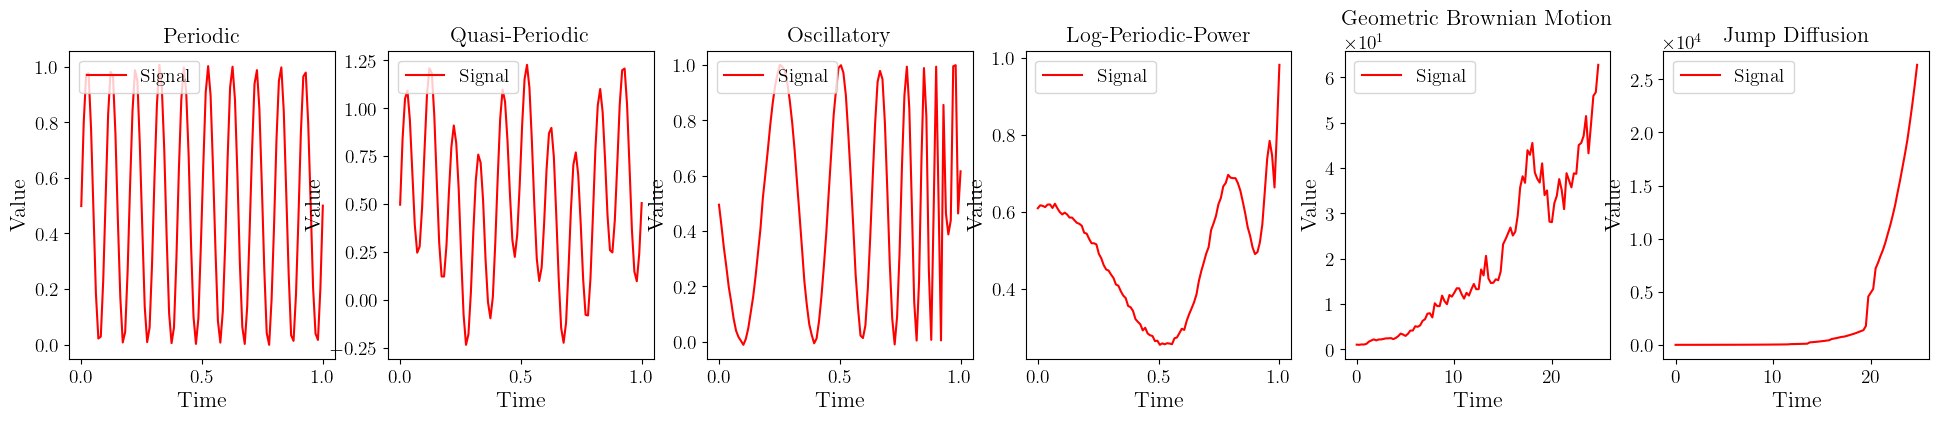

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from frameworks.data.time_series import generate_time_series
from frameworks.tda.embedding import embedding_time_series
from frameworks.utils.plots import plot_run_chart
from frameworks.utils.helpers import title
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude

figsize = 4

signal_types = ["periodic", "quasi-periodic", "oscillatory", "log-periodic-power", "geometric_brownian_motion", "jump_diffusion"]#, "geometric_random_walk", "random_walk_critical", "sawtooth", "random", "spike", "step"]
length = 100
embedding_delay = 1
embedding_dimension = 2
sliding_window_size = 50
sliding_stride = 1

signals = []
fig, axes = plt.subplots(1, len(signal_types), figsize=(figsize * len(signal_types), figsize))
for i, signal_type in enumerate(signal_types):
    t, signal = generate_time_series(
        length=length,
        signal_type=signal_type,
        snr=40,
        amplitude=1,
        frequency=10,
        amplitude_ratio=0.25,
        frequency_ratio=0.25,
        alpha=0.25,
        exponential_factor=-1,
        nonlinearity=0.3,
        critical_time=0.75
    )
    signals.append(signal)
    plot_run_chart(axes[i], t, signal, label="Signal")
    axes[i].set_title(title(signal_type))

embedded_signals = [embedding_time_series(signal, embedding_delay, embedding_dimension, sliding_window_size, stride=sliding_stride) for signal in signals]

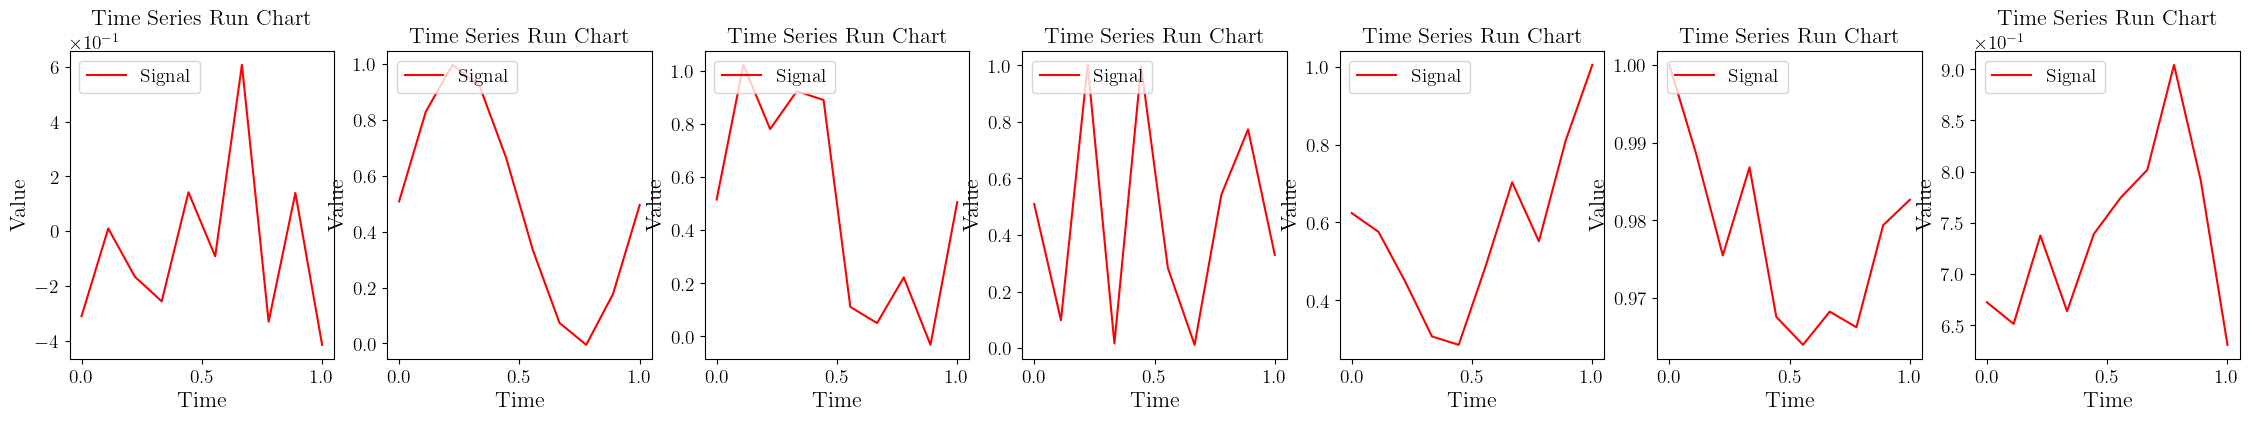

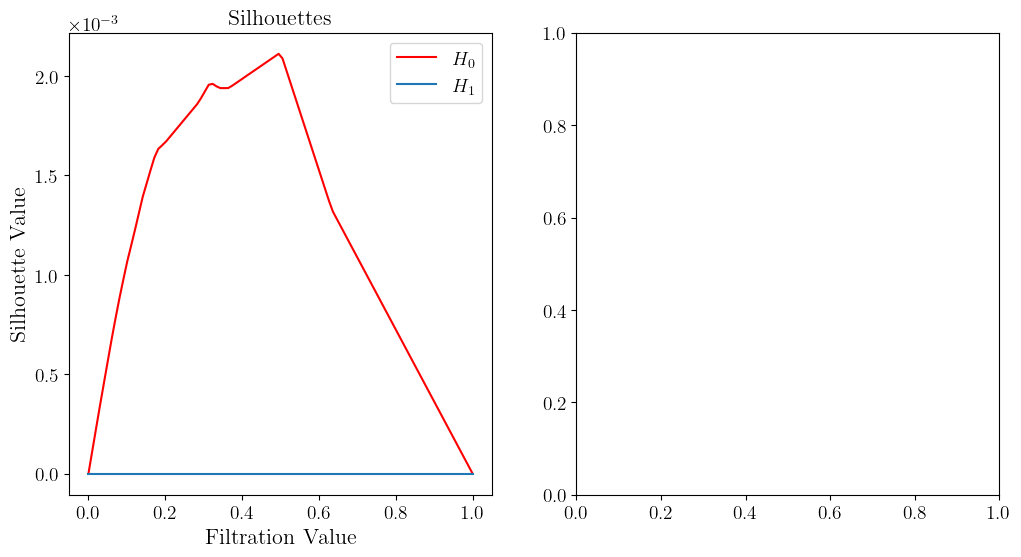

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from frameworks.data.time_series import generate_time_series
from frameworks.tda.embedding import embedding_time_series
from frameworks.utils.plots import plot_run_chart, plot_persistence_diagram, plot_silhouettes
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude

figsize = 4

signal_types = ["random", "periodic", "quasi-periodic", "oscillatory", "log-periodic-power", "geometric_random_walk", "random_walk_critical"]
length = 10
embedding_delay = 1
embedding_dimension = 2
sliding_window_size = 5
sliding_stride = 1

signals = []
fig, axes = plt.subplots(1, len(signal_types), figsize=(figsize * len(signal_types), figsize))
for i, signal_type in enumerate(signal_types):
    t, signal = generate_time_series(
        length=length,
        signal_type=signal_type,
        snr=40,
        amplitude=1,
        frequency=10,
        amplitude_ratio=0.25,
        frequency_ratio=0.3,
        alpha=0.5,
        exponential_factor=-1,
        nonlinearity=0.5,
        critical_time=0.75
    )
    signals.append(signal)
    plot_run_chart(axes[i], t, signal, label="Signal")

embedded_signals = [embedding_time_series(signal, embedding_delay, embedding_dimension, sliding_window_size, stride=sliding_stride) for signal in signals]


class TopoAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(TopoAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


# class TopoAutoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(TopoAutoencoder, self).__init__()
#
#         # Encoder using LSTM
#         self.encoder = nn.LSTM(input_dim, latent_dim, batch_first=True)
#
#         # Decoder
#         self.decoder = nn.LSTM(latent_dim, input_dim, batch_first=True)
#
#     def forward(self, x):
#         _, (z, _) = self.encoder(x)  # Get last hidden state
#         x_recon, _ = self.decoder(z.unsqueeze(0))  # Decode latent state
#         return x_recon, z.squeeze(0)


def compute_persistence_diagram(data):
    """Compute persistence diagram using Vietoris-Rips complex."""
    diagrams = []
    for signal in data:  # Iterate over batch
        signal = signal.reshape(-1, 1)  # Reshape each individual sequence

        vr = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
        diagrams.append(vr.fit_transform([signal]))  # Pass as a list
    return diagrams


def topological_loss(diagrams_x, diagrams_z):
    """Compute topological loss as the difference in persistence diagrams."""
    amplitude = Amplitude(metric="wasserstein", metric_params={"p": 1})
    loss_x = amplitude.fit_transform(diagrams_x)
    loss_z = amplitude.fit_transform(diagrams_z)
    return torch.tensor(np.mean(np.abs(loss_x - loss_z)), requires_grad=True)


# Training Setup
latent_dim = 2  # Low-dimensional space
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopoAutoencoder(input_dim=embedding_dimension, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# Training Loop
# Training Loop
num_epochs = 1
# Convert embedded_signals to a batch tensor (3D: batch_size, seq_length, embedding_dim)
x = torch.stack([torch.tensor(signal[0], dtype=torch.float32) for signal in embedded_signals]).to(device)

for epoch in range(num_epochs):
    total_loss = 0

    optimizer.zero_grad()

    # Forward pass
    x_recon, z = model(x)

    # Compute persistence diagrams for each sample in batch
    diagrams_x = compute_persistence_diagram(x.cpu().detach().numpy())[0]
    diagrams_z = compute_persistence_diagram(z.cpu().detach().numpy())[0]

    # Compute losses
    loss_recon = mse_loss(x_recon, x)
    loss_topo = topological_loss(diagrams_x, diagrams_z)
    loss = loss_recon + 0.1 * loss_topo  # Weighted combination

    # Backpropagation
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    # Logging
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}")

signal_idx = 5
signal = embedded_signals[signal_idx]

# Compute Persistence Diagrams
diagrams_x = compute_persistence_diagram(signal)
diagrams_z = compute_persistence_diagram(
    model.encoder(torch.tensor(signal[0], dtype=torch.float32).to(device)).cpu().detach().numpy())

z = model.encoder(torch.tensor(signal[0], dtype=torch.float32).to(device)).clone().detach()
x_rec = model.decoder(z).cpu().detach()
diagrams_x_rec = compute_persistence_diagram(x_rec.numpy())


from gtda.diagrams import Silhouette
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
silhouette = Silhouette(power=1, n_jobs=-1)
silhouettes = silhouette.fit_transform(diagrams_x[0])
plot_silhouettes(silhouettes[0], axes[0])
# axes[0].set_title("Persistence Diagram - Input Space")
# 
# plot_persistence_diagram(diagrams_z[0][0], ax=axes[1])
# axes[1].set_title("Persistence Diagram - Latent Space")
plt.show()

# Compute evaluation metrics
# mse_losses = []
# topo_losses = []
#
# for signal in embedded_signals:
#     x = torch.tensor(signal[0], dtype=torch.float32).to(device)
#     x_recon, z = model(x)
#
#     # Compute persistence diagrams
#     diagrams_x = compute_persistence_diagram(x.cpu().detach().numpy())[0]
#     diagrams_z = compute_persistence_diagram(z.cpu().detach().numpy())[0]
#
#     # Compute losses
#     mse_losses.append(mse_loss(x_recon, x).item())
#     topo_losses.append(topological_loss(diagrams_x, diagrams_z).item())
#
# # Print Table
# import pandas as pd
# df_results = pd.DataFrame({"Signal Type": signal_types, "MSE Loss": mse_losses, "Topological Loss": topo_losses})
# print(df_results)

metrics_list = {
        "bottleneck": {},  # No parameters required
        "wasserstein": {"p": 1},  # L1 norm
        "betti": {"p": 1, "n_bins": 100},  # Includes binning for Betti curves
        "landscape": {"p": 1, "n_bins": 100},  # L1 norm and binning for persistence landscapes
        "silhouette": {"p": 1, "power": 1.0, "n_bins": 100},  # L1 norm, power-weighted silhouette
        # "heat": {"p": 1, "sigma": 0.1, "n_bins": 100},  # Heat kernel smoothing with sigma
        # "persistence_image": {"p": 1, "sigma": 0.1, "n_bins": 100},  # Persistence image with Gaussian smoothing
        "entropy": {},  # No parameters required
    }
homologies_show = [0, 1]

fig, axs = plt.subplots(len(metrics_list), len(signal_types), figsize=(len(signal_types) * fig_size, (len(metrics_list)) * fig_size))

for j, signal_type in enumerate(signal_types):
    signal = signals[j]
    
    embedding_sequence, embedding_indices = embedding_time_series(signal, embedding_delay, embedding_dimension, sliding_window_size, stride=sliding_stride)
    
    metrics = compute_topological_metrics(embedding_sequence, metrics_list, homologies_show)

    for i, (metric, values) in enumerate(metrics.items()):
        plot_run_chart(axs[i, j], t, signal, signal_type, linestyle=':', color='grey')

    plot_topological_signature_time_series(embedding_indices, metrics, length, signal_type, axs[:, j], homologies_show)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class DifferentiableTopologicalLoss(nn.Module):
    """
    PyTorch differentiable Wasserstein loss between persistence landscapes.
    """
    def __init__(self, num_layers=10, num_points=100):
        """
        Parameters:
        - num_layers: Number of layers in the persistence landscape.
        - num_points: Number of points for the persistence landscape.
        """
        super(DifferentiableTopologicalLoss, self).__init__()
        self.num_layers = num_layers
        self.num_points = num_points

    def compute_distance_matrix(self, X):
        """
        Compute squared Euclidean distance matrix for a batch of point clouds.
        """
        batch_size, num_points, dim = X.shape
        X = X.unsqueeze(2)  # (batch_size, num_points, 1, dim)
        Y = X.transpose(1, 2)  # (batch_size, 1, num_points, dim)

        return torch.sum((X - Y) ** 2, dim=-1)  # (batch_size, num_points, num_points)

    def compute_persistence_diagram(self, X):
        """
        Compute an **approximate** persistence diagram using a differentiable approach.
        """
        D = self.compute_distance_matrix(X)  # Compute pairwise distances
        D_sorted, _ = torch.sort(D, dim=-1)  # Sort distances

        birth = D_sorted[:, :, 1]  # Approximate birth times (second smallest distance)
        death = D_sorted[:, :, 2]  # Approximate death times (third smallest distance)

        persistence_diagram = torch.stack([birth, death], dim=-1)  # Shape (batch, num_points, 2)
        return persistence_diagram

    def compute_persistence_landscape(self, persistence_diagram):
        """
        Compute differentiable persistence landscape.
        """
        batch_size, num_points, _ = persistence_diagram.shape
        t_values = torch.linspace(torch.min(persistence_diagram), 
                                  torch.max(persistence_diagram), 
                                  self.num_points, device=persistence_diagram.device)

        landscape = torch.zeros((batch_size, self.num_layers, self.num_points), device=persistence_diagram.device)

        for i in range(self.num_layers):
            if i >= num_points:
                break
            birth, death = persistence_diagram[:, i, 0], persistence_diagram[:, i, 1]
            mid = (birth + death) / 2

            left_slope = (t_values - birth.unsqueeze(-1)) / (mid.unsqueeze(-1) - birth.unsqueeze(-1))
            right_slope = (death.unsqueeze(-1) - t_values) / (death.unsqueeze(-1) - mid.unsqueeze(-1))

            layer = torch.max(torch.min(left_slope, right_slope), torch.tensor(0.0, device=t_values.device))
            landscape[:, i] = layer

        return landscape

    def wasserstein_distance(self, pl1, pl2):
        """
        Compute differentiable Wasserstein distance between two persistence landscapes.
        """
        diff = torch.abs(pl1 - pl2)
        return torch.trapz(diff, dx=1.0 / self.num_points)

    def forward(self, X1, X2):
        """
        Compute topological loss between two point clouds.
        """
        diag_X1 = self.compute_persistence_diagram(X1)
        diag_X2 = self.compute_persistence_diagram(X2)

        pl_X1 = self.compute_persistence_landscape(diag_X1)
        pl_X2 = self.compute_persistence_landscape(diag_X2)

        return self.wasserstein_distance(pl_X1, pl_X2)


class TopoAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(TopoAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


# Training Setup
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TopoAutoencoder(input_dim=2, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
topo_loss_fn = DifferentiableTopologicalLoss(num_layers=10, num_points=100).to(device)

# Sample Input: Batch of point clouds (batch_size, num_points, dim)
batch_size = 32
num_points = 50
dim = 2

X = torch.rand(batch_size, num_points, dim, device=device, requires_grad=True)

# Training Loop
# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    x_recon, z = model(X)

    loss_recon = mse_loss(x_recon, X)
    loss_topo = topo_loss_fn(X, z).mean()  # Ensure it's a scalar
    loss = loss_recon + 0.1 * loss_topo  # Weighted combination

    loss.backward()  # ✅ Now loss is scalar, no more RuntimeError
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Recon: {loss_recon.item():.4f}, Topo: {loss_topo.item():.4f}")

Epoch [10/100], Loss: 0.1206, Recon: 0.1184, Topo: 0.0225
Epoch [20/100], Loss: 0.0935, Recon: 0.0916, Topo: 0.0193
Epoch [30/100], Loss: 0.0702, Recon: 0.0675, Topo: 0.0269
Epoch [40/100], Loss: 0.0547, Recon: 0.0532, Topo: 0.0147
Epoch [50/100], Loss: 0.0329, Recon: 0.0311, Topo: 0.0179
Epoch [60/100], Loss: 0.0180, Recon: 0.0163, Topo: 0.0173
Epoch [70/100], Loss: 0.0082, Recon: 0.0057, Topo: 0.0245
Epoch [80/100], Loss: 0.0035, Recon: 0.0006, Topo: 0.0293
Epoch [90/100], Loss: 0.0032, Recon: 0.0007, Topo: 0.0254
Epoch [100/100], Loss: 0.0021, Recon: 0.0004, Topo: 0.0166
